In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

d:\work\DataScience\cs6010_fa2024_project_g06\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# List of relevant columns
columns_to_use = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 
                  'trip_distance', 'fare_amount', 'total_amount']

In [3]:
df2024_1 = pd.read_parquet('../data/raw/yellow_tripdata_2024-01.parquet', columns=columns_to_use)
df2024_2 = pd.read_parquet('../data/raw/yellow_tripdata_2024-02.parquet', columns=columns_to_use)
df2024_3 = pd.read_parquet('../data/raw/yellow_tripdata_2024-03.parquet', columns=columns_to_use)
df2024_4 = pd.read_parquet('../data/raw/yellow_tripdata_2024-04.parquet', columns=columns_to_use)
df2024_5 = pd.read_parquet('../data/raw/yellow_tripdata_2024-05.parquet', columns=columns_to_use)
df2024_6 = pd.read_parquet('../data/raw/yellow_tripdata_2024-06.parquet', columns=columns_to_use)

df2024 = pd.concat([df2024_1, df2024_2, df2024_3, df2024_4, df2024_5, df2024_6])

In [4]:
df2023_1 = pd.read_parquet('../data/raw/2023/yellow_tripdata_2023-01.parquet', columns=columns_to_use)
df2023_2 = pd.read_parquet('../data/raw/2023/yellow_tripdata_2023-02.parquet', columns=columns_to_use)
df2023_3 = pd.read_parquet('../data/raw/2023/yellow_tripdata_2023-03.parquet', columns=columns_to_use)
df2023_4 = pd.read_parquet('../data/raw/2023/yellow_tripdata_2023-04.parquet', columns=columns_to_use)
df2023_5 = pd.read_parquet('../data/raw/2023/yellow_tripdata_2023-05.parquet', columns=columns_to_use)
df2023_6 = pd.read_parquet('../data/raw/2023/yellow_tripdata_2023-06.parquet', columns=columns_to_use)
df2023_7 = pd.read_parquet('../data/raw/2023/yellow_tripdata_2023-07.parquet', columns=columns_to_use)
df2023_8 = pd.read_parquet('../data/raw/2023/yellow_tripdata_2023-08.parquet', columns=columns_to_use)
df2023_9 = pd.read_parquet('../data/raw/2023/yellow_tripdata_2023-09.parquet', columns=columns_to_use)
df2023_10 = pd.read_parquet('../data/raw/2023/yellow_tripdata_2023-10.parquet', columns=columns_to_use)
df2023_11 = pd.read_parquet('../data/raw/2023/yellow_tripdata_2023-11.parquet', columns=columns_to_use)
df2023_12 = pd.read_parquet('../data/raw/2023/yellow_tripdata_2023-12.parquet', columns=columns_to_use)

In [5]:
df2023 = pd.concat([df2023_1, df2023_2, df2023_3, df2023_4, df2023_5, df2023_6, df2023_7, df2023_8, df2023_9, df2023_10, df2023_11, df2023_12])

In [6]:
df2023.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38310226 entries, 0 to 3376566
Data columns (total 6 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[us]
 1   tpep_dropoff_datetime  datetime64[us]
 2   passenger_count        float64       
 3   trip_distance          float64       
 4   fare_amount            float64       
 5   total_amount           float64       
dtypes: datetime64[us](2), float64(4)
memory usage: 2.0 GB


In [7]:
pd.DataFrame({
    'feature': df2023.columns.values,
    'data_type': df2023.dtypes.values,
    'null_value(%)': df2023.isna().mean().values * 100,
    'neg_value(%)': [len(df2023[col][df2023[col] < 0]) / len(df2023) * 100 if col in df2023.select_dtypes(include=[np.number]).columns else 0 for col in df2023.columns],
    '0_value(%)': [len(df2023[col][df2023[col] == 0]) / len(df2023) * 100 if col in df2023.select_dtypes(include=[np.number]).columns else 0 for col in df2023.columns],
    'duplicate' : df2023.duplicated().sum(),
    'min': [df2023[col].min() if col in df2023.select_dtypes(include=[np.number]).columns else None for col in df2023.columns],
    'max': [df2023[col].max() if col in df2023.select_dtypes(include=[np.number]).columns else None for col in df2023.columns],
    'n_unique': df2023.nunique().values,
    'sample_unique': [df2023[col].unique() for col in df2023.columns]}
).round(3)

KeyboardInterrupt: 

### Handling Duplicates

In [8]:
df2023[df2023.duplicated()]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount
934472,2023-01-11 15:50:58,2023-01-11 15:56:38,1.0,0.72,7.2,13.44
2072898,2023-03-20 06:53:45,2023-03-20 06:57:24,1.0,0.96,6.5,12.60
2274245,2023-03-22 09:39:23,2023-03-22 09:46:39,1.0,0.92,8.6,15.12
1276894,2023-06-12 16:51:28,2023-06-12 17:00:07,1.0,2.02,11.4,17.90
466543,2023-07-07 12:18:08,2023-07-07 12:18:41,1.0,0.00,3.0,4.50
1117288,2023-07-14 09:22:43,2023-07-14 09:26:09,1.0,0.40,5.8,11.75
687183,2023-09-08 12:33:01,2023-09-08 12:33:26,1.0,0.00,3.0,4.50
199209,2023-10-03 06:51:31,2023-10-03 06:58:00,1.0,0.90,7.9,14.25
1413329,2023-11-13 13:26:12,2023-11-13 14:48:41,1.0,18.87,70.0,97.13
1432572,2023-11-13 13:57:30,2023-11-13 14:54:16,1.0,18.02,70.0,85.94


In [9]:
df2023.drop_duplicates(inplace= True)

In [10]:
duplicate_value = df2023[df2023.duplicated(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance'], keep=False)]
duplicate_value

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount
132,2023-01-01 00:28:29,2023-01-01 00:31:03,1.0,0.42,-5.1,-10.1
133,2023-01-01 00:28:29,2023-01-01 00:31:03,1.0,0.42,5.1,10.1
263,2023-01-01 00:20:18,2023-01-01 00:27:56,2.0,1.19,-9.3,-14.3
264,2023-01-01 00:20:18,2023-01-01 00:27:56,2.0,1.19,9.3,14.3
324,2023-01-01 00:52:22,2023-01-01 01:14:03,1.0,4.89,-25.4,-30.4
...,...,...,...,...,...,...
3196479,2023-12-31 23:11:52,2023-12-31 23:20:02,1.0,1.44,10.7,13.2
3196508,2023-12-31 23:31:55,2023-12-31 23:57:24,1.0,0.63,-19.1,-24.1
3196509,2023-12-31 23:31:55,2023-12-31 23:57:24,1.0,0.63,19.1,24.1
3196521,2023-12-31 23:00:36,2023-12-31 23:00:43,1.0,0.00,-3.0,-8.0


In [11]:
dup_negative_val = duplicate_value[duplicate_value['fare_amount']<0]
dup_negative_val 

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount
132,2023-01-01 00:28:29,2023-01-01 00:31:03,1.0,0.42,-5.1,-10.1
263,2023-01-01 00:20:18,2023-01-01 00:27:56,2.0,1.19,-9.3,-14.3
324,2023-01-01 00:52:22,2023-01-01 01:14:03,1.0,4.89,-25.4,-30.4
620,2023-01-01 00:06:39,2023-01-01 00:10:02,1.0,0.52,-5.1,-10.1
923,2023-01-01 00:34:39,2023-01-01 00:40:25,2.0,0.85,-7.2,-12.2
...,...,...,...,...,...,...
3196444,2023-12-31 23:51:34,2023-12-31 23:57:31,2.0,0.48,-5.1,-10.1
3196473,2023-12-31 23:55:57,2024-01-01 00:19:38,1.0,1.11,-19.8,-24.8
3196478,2023-12-31 23:11:52,2023-12-31 23:20:02,1.0,1.44,-10.7,-13.2
3196508,2023-12-31 23:31:55,2023-12-31 23:57:24,1.0,0.63,-19.1,-24.1


In [12]:
df2023.drop(dup_negative_val.index, inplace=True)

In [13]:
df2023[df2023.duplicated(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime',  'passenger_count', 'trip_distance'])]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount
76201,2023-01-02 04:23:28,2023-01-02 04:23:58,3.0,0.02,0.0,1.00
76508,2023-01-02 05:12:19,2023-01-02 05:41:45,1.0,17.07,0.0,1.00
76952,2023-01-02 06:32:52,2023-01-02 07:05:44,1.0,16.71,0.0,5.25
87766,2023-01-02 11:03:12,2023-01-02 11:05:47,1.0,0.01,0.0,4.00
153088,2023-01-03 09:32:18,2023-01-03 09:32:53,1.0,0.14,0.0,2.75
...,...,...,...,...,...,...
3060020,2023-12-30 09:04:07,2023-12-30 09:11:03,1.0,0.67,0.0,4.00
3099326,2023-12-30 17:46:39,2023-12-30 17:46:50,2.0,0.01,0.0,4.00
3138529,2023-12-31 09:42:36,2023-12-31 09:43:56,2.0,0.15,0.0,4.00
3171724,2023-12-31 17:43:24,2023-12-31 17:43:33,3.0,0.00,0.0,4.00


In [14]:
df2023.drop_duplicates(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance'], keep=False)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount
0,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,9.30,14.30
2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,14.90,34.90
3,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,12.10,20.85
4,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,11.40,19.68
5,2023-01-01 00:50:34,2023-01-01 01:02:52,1.0,1.84,12.80,27.80
...,...,...,...,...,...,...
3376562,2023-12-31 23:04:34,2023-12-31 23:13:58,NaN,1.34,12.08,16.08
3376563,2023-12-31 23:08:15,2023-12-31 23:08:23,NaN,0.00,25.98,27.48
3376564,2023-12-31 23:16:15,2023-12-31 23:30:28,NaN,3.71,16.68,18.18
3376565,2023-12-31 23:21:58,2023-12-31 23:34:29,NaN,5.20,19.64,23.64


In [15]:
df2023.shape

(34184419, 6)

In [16]:
df2023[df2023.duplicated(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime',  'passenger_count', 'trip_distance'])]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount
76201,2023-01-02 04:23:28,2023-01-02 04:23:58,3.0,0.02,0.0,1.00
76508,2023-01-02 05:12:19,2023-01-02 05:41:45,1.0,17.07,0.0,1.00
76952,2023-01-02 06:32:52,2023-01-02 07:05:44,1.0,16.71,0.0,5.25
87766,2023-01-02 11:03:12,2023-01-02 11:05:47,1.0,0.01,0.0,4.00
153088,2023-01-03 09:32:18,2023-01-03 09:32:53,1.0,0.14,0.0,2.75
...,...,...,...,...,...,...
3060020,2023-12-30 09:04:07,2023-12-30 09:11:03,1.0,0.67,0.0,4.00
3099326,2023-12-30 17:46:39,2023-12-30 17:46:50,2.0,0.01,0.0,4.00
3138529,2023-12-31 09:42:36,2023-12-31 09:43:56,2.0,0.15,0.0,4.00
3171724,2023-12-31 17:43:24,2023-12-31 17:43:33,3.0,0.00,0.0,4.00


In [17]:
df2023.shape

(34184419, 6)

In [18]:
print(df2023.index.duplicated().sum())

31017928


In [19]:
df2023.reset_index(drop=True, inplace=True)

In [20]:
print(df2023.index.duplicated().sum())

0


In [21]:
df2023.shape

(34184419, 6)

## Negative Values

In [22]:
pd.DataFrame({
    'feature': df2023.columns.values,
    'neg_value(%)': [len(df2023[col][df2023[col] < 0]) / len(df2023) * 100 if np.issubdtype(df2023[col].dtype, np.number) else 0 for col in df2023.columns]
}).round(3)

,feature,neg_value(%)
0,tpep_pickup_datetime,0.000
1,tpep_dropoff_datetime,0.000
2,passenger_count,0.000
3,trip_distance,0.000
4,fare_amount,0.020
5,total_amount,0.006


In [23]:
negative_val  = df2023[df2023['fare_amount']<0]
df2023.loc[negative_val.index, 'fare_amount'] = df2023['fare_amount'].abs()

## Zero Values

In [24]:
pd.DataFrame({
    'feature': df2023.columns.values,
    'data_type': df2023.dtypes.values,
    '0_value(%)': [len(df2023[col][df2023[col] == 0]) / len(df2023) * 100 if np.issubdtype(df2023[col].dtype, np.number) else 0 for col in df2023.columns]
}).round(3)

,feature,data_type,0_value(%)
0,tpep_pickup_datetime,datetime64[us],0.000
1,tpep_dropoff_datetime,datetime64[us],0.000
2,passenger_count,float64,1.533
3,trip_distance,float64,1.977
4,fare_amount,float64,0.034
5,total_amount,float64,0.016


In [25]:
median_passenger_count = df2023[df2023['passenger_count'] > 0]['passenger_count'].median()
df2023['passenger_count'] = df2023['passenger_count'].apply(lambda x: x if (x > 0 )  else median_passenger_count)

df2023 = df2023[df2023['trip_distance']>0]
df2023 = df2023[df2023['fare_amount']>0]

## Missing Values


In [26]:
pd.DataFrame({
    'feature': df2023.columns.values,
    'data_type': df2023.dtypes.values,
    'null_value(%)': df2023.isna().mean().values * 100
}).round(3)

,feature,data_type,null_value(%)
0,tpep_pickup_datetime,datetime64[us],0.0
1,tpep_dropoff_datetime,datetime64[us],0.0
2,passenger_count,float64,0.0
3,trip_distance,float64,0.0
4,fare_amount,float64,0.0
5,total_amount,float64,0.0


In [27]:
df2023['passenger_count'].fillna(df2023['passenger_count'].median(), inplace=True)
df2023['passenger_count'].value_counts()

C:\Users\ACER\AppData\Local\Temp\ipykernel_33336\2750639887.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2023['passenger_count'].fillna(df2023['passenger_count'].median(), inplace=True)


passenger_count
1.0    25937342
2.0     4940625
3.0     1227655
4.0      683767
5.0      430411
6.0      282976
8.0          84
7.0          42
9.0          24
Name: count, dtype: int64

In [28]:
outliers = df2023[(df2023['tpep_pickup_datetime'].dt.year!=2023)]
outliers

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount
65,2022-12-31 23:51:30,2022-12-31 23:56:06,1.0,0.86,6.50,13.50
489,2022-12-31 23:59:37,2023-01-01 00:07:28,1.0,2.38,12.10,21.38
652,2022-12-31 23:58:27,2023-01-01 00:02:21,1.0,0.49,5.80,10.88
768,2022-12-31 23:44:31,2022-12-31 23:48:47,1.0,0.52,5.80,12.96
997,2022-12-31 23:59:25,2023-01-01 00:19:21,2.0,3.65,19.10,31.33
...,...,...,...,...,...,...
33652806,2024-01-03 10:00:04,2024-01-03 11:08:22,1.0,21.60,82.10,110.75
33652808,2024-01-03 18:43:26,2024-01-03 18:43:29,2.0,0.01,86.69,105.23
33652809,2024-01-03 19:42:57,2024-01-03 20:15:55,1.0,16.67,65.30,73.55
34008558,2024-01-01 00:01:34,2024-01-01 00:05:41,1.0,0.71,6.50,11.50


In [29]:
df2023.drop(outliers.index, inplace=True)

In [30]:
df2023[(df2023['tpep_pickup_datetime'].dt.year!=2023)]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount


In [31]:
time_bins = [0, 5, 11, 15, 20, 24] 
time_labels = ['Midnight', 'Morning', 'Noon', 'Evening', 'Night']
df2023['pickup_time'] = pd.cut(df2023['tpep_pickup_datetime'].dt.hour, bins=time_bins, labels=time_labels, right=False)

df2023['day_category'] = df2023['tpep_pickup_datetime'].dt.day_name().apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekdays')

### Trip Distance

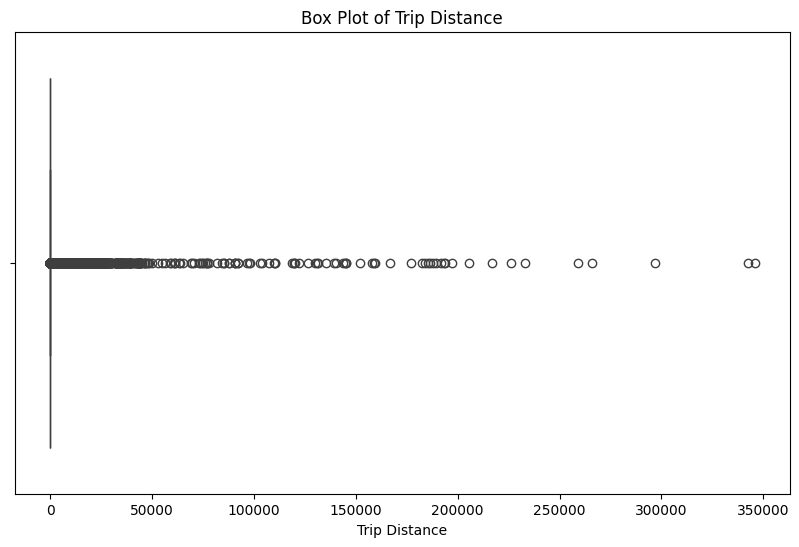

In [32]:
# Create a boxplot for trip_distance
plt.figure(figsize=(10, 6))
sns.boxplot(x=df2023['trip_distance'])
plt.title('Box Plot of Trip Distance')
plt.xlabel('Trip Distance')
plt.show()

In [33]:
df2023 = df2023[df2023['trip_distance']>1]

In [34]:
df2023[df2023['trip_distance']>120].sort_values(by='trip_distance', ascending=False).shape

(1033, 8)

In [35]:
df2023 = df2023[df2023['trip_distance']<120]

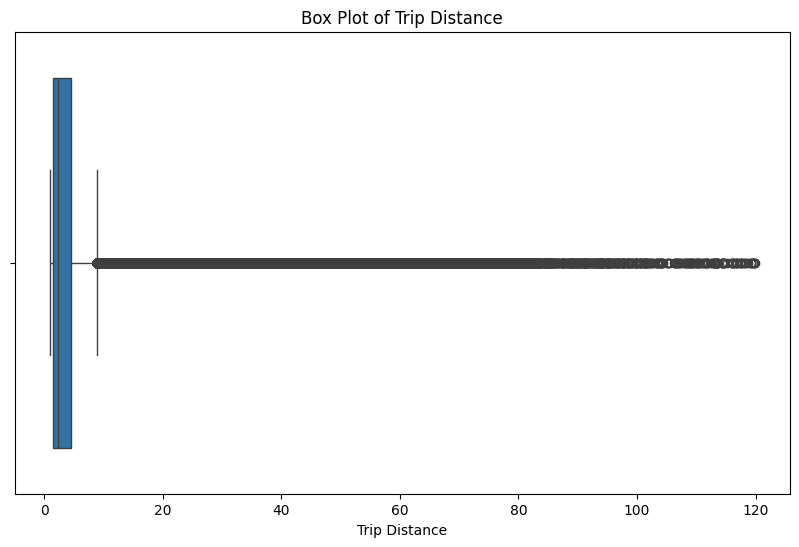

In [36]:
# Create a boxplot for trip_distance
plt.figure(figsize=(10, 6))
sns.boxplot(x=df2023['trip_distance'])
plt.title('Box Plot of Trip Distance')
plt.xlabel('Trip Distance')
plt.show()

### Fare Amount

In [37]:
df2023[df2023['fare_amount']>120].sort_values(by='trip_distance', ascending=False).head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount,pickup_time,day_category
31461537,2023-12-03 20:28:49,2023-12-03 22:30:18,1.0,119.84,822.0,830.94,Night,Weekend
24114421,2023-09-19 06:46:57,2023-09-19 09:46:46,1.0,119.75,446.8,495.67,Morning,Weekdays
32892959,2023-12-17 11:28:38,2023-12-17 13:24:51,1.0,119.71,300.0,346.38,Noon,Weekend
27653655,2023-10-28 07:51:38,2023-10-28 09:04:36,1.0,119.70,354.4,376.84,Morning,Weekend
21977217,2023-08-26 10:31:13,2023-08-26 13:32:16,5.0,119.64,778.6,798.55,Morning,Weekend


### Feature Creation -- trip_duration

In [38]:
diff = (df2023['tpep_dropoff_datetime'] - df2023['tpep_pickup_datetime']).dt.total_seconds()/60
df2023['trip_duration'] = diff.round(2)

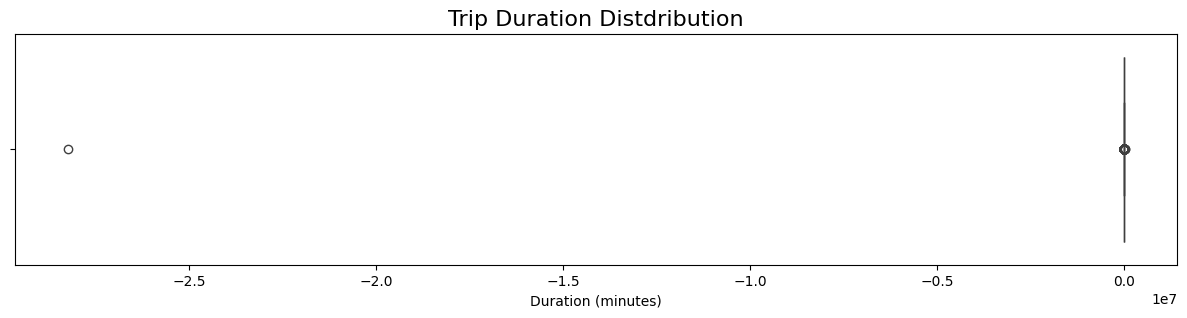

In [39]:
plt.figure(figsize=(15, 3))

sns.boxplot(data=df2023, x='trip_duration')
plt.xlabel('Duration (minutes)')
plt.title('Trip Duration Distdribution', fontsize=16)


plt.show()

 With the furthest recorded distance, which is 114 miles, when traveled at the lowest average speed in New York City, which is 10 mph, the time required would be 11.4 hours (or about 684 minutes). Therefore, any trip duration exceeding this calculated time can be considered an extreme outlier, as it would be unusually long for a taxi ride. Based on this, any records with durations significantly exceeding 684 minutes can be flagged as extreme outliers, suggesting that these values are likely unnatural or erroneous.

In [40]:
df2023[df2023['trip_duration']>700].sort_values(by='trip_duration', ascending=False).head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount,pickup_time,day_category,trip_duration
4739953,2023-02-23 14:59:05,2023-02-28 12:32:42,1.0,14.34,80.0,82.75,Noon,Weekdays,7053.62
18380877,2023-07-14 00:29:36,2023-07-18 15:06:03,1.0,10.99,47.1,58.65,Midnight,Weekdays,6636.45
1262870,2023-01-16 10:20:33,2023-01-20 17:19:57,1.0,17.69,70.0,80.55,Morning,Weekdays,6179.40
29708857,2023-11-16 08:39:40,2023-11-20 04:21:23,1.0,16.03,78.6,81.85,Morning,Weekdays,5501.72
32721317,2023-12-15 19:36:10,2023-12-19 13:14:07,1.0,3.01,38.7,44.45,Evening,Weekdays,5377.95


In [41]:
df2023 = df2023[df2023['trip_duration']<700]

In [42]:
df2023 = df2023[df2023['trip_duration']>0]

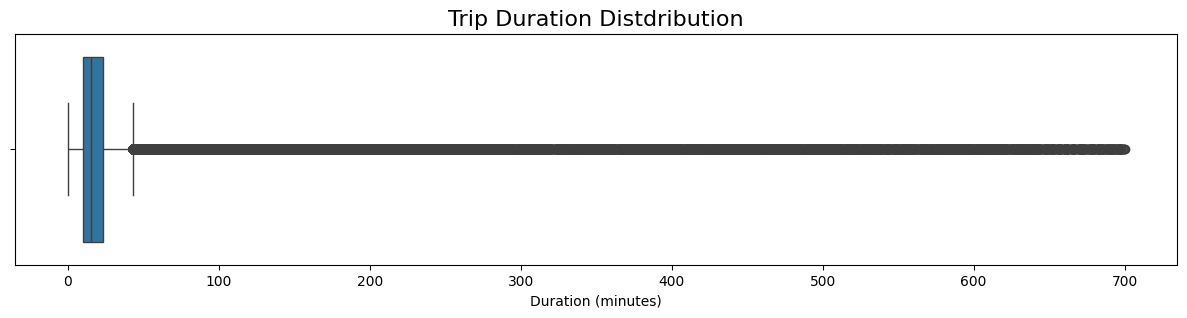

In [43]:
plt.figure(figsize=(15, 3))

sns.boxplot(data=df2023, x='trip_duration')
plt.xlabel('Duration (minutes)')
plt.title('Trip Duration Distdribution', fontsize=16)


plt.show()

# Group data by hour of the day

In [44]:
# Extract hour, day of the week, month, and season from pickup datetime
df2023['hour'] = df2023['tpep_pickup_datetime'].dt.hour
df2023['day_of_week'] = df2023['tpep_pickup_datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
df2023['month'] = df2023['tpep_pickup_datetime'].dt.month

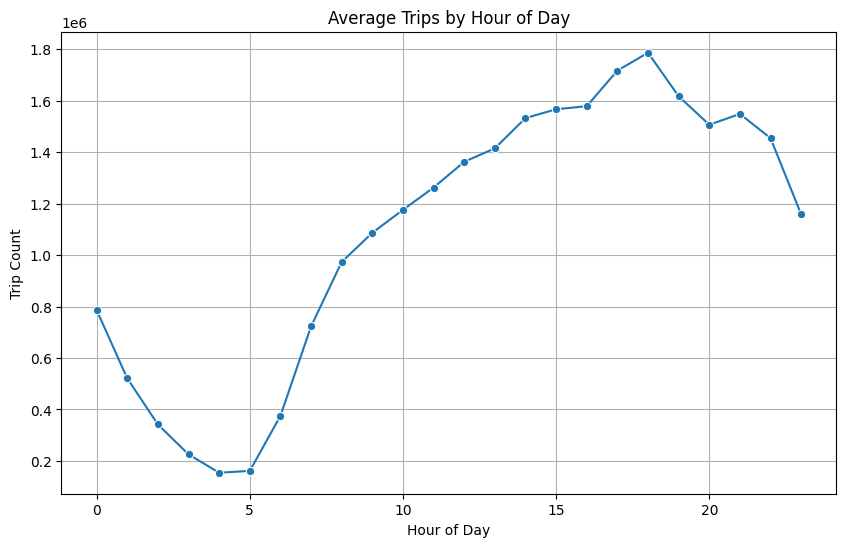

In [45]:
# Aggregate trips by hour
hourly_demand = df2023.groupby('hour').size().reset_index(name='trip_count')

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='trip_count', data=hourly_demand, marker='o')
plt.title('Average Trips by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Trip Count')
plt.grid()
plt.show()

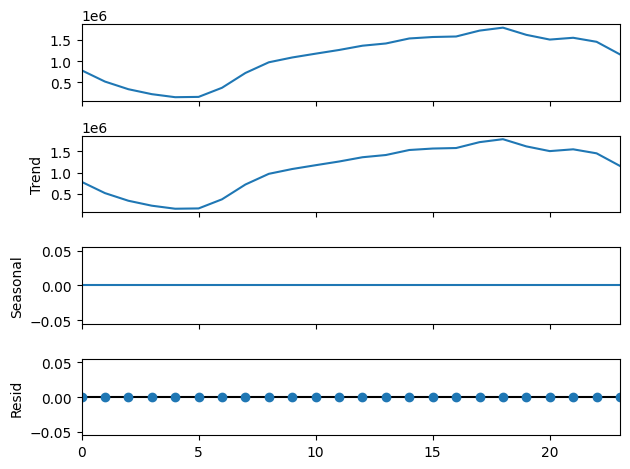

In [46]:
hourly_demand = df2023.groupby(df2023['tpep_pickup_datetime'].dt.hour).size()
hourly_decomposition = seasonal_decompose(hourly_demand, model="additive", period=1)  # 24 hours in a day

hourly_decomposition.plot()
plt.show()

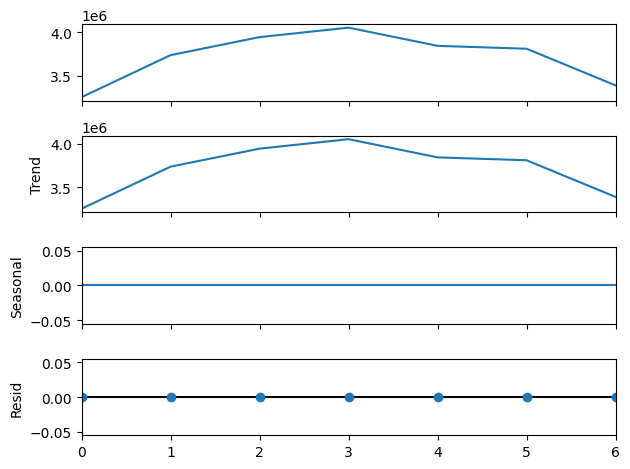

In [47]:
weekly_demand = df2023.groupby(df2023['tpep_pickup_datetime'].dt.day_of_week).size()
weekly_decomposition = seasonal_decompose(weekly_demand, model="additive", period=1)  # 24 hours in a day

weekly_decomposition.plot()
plt.show()

In [48]:
# Extract hour, day of the week, month, and season from pickup datetime
df2023['hour'] = df2023['tpep_pickup_datetime'].dt.hour
df2023['day_of_week'] = df2023['tpep_pickup_datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
df2023['month'] = df2023['tpep_pickup_datetime'].dt.month

In [49]:
df2023.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26030666 entries, 1 to 34184418
Data columns (total 12 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[us]
 1   tpep_dropoff_datetime  datetime64[us]
 2   passenger_count        float64       
 3   trip_distance          float64       
 4   fare_amount            float64       
 5   total_amount           float64       
 6   pickup_time            category      
 7   day_category           object        
 8   trip_duration          float64       
 9   hour                   int32         
 10  day_of_week            int32         
 11  month                  int32         
dtypes: category(1), datetime64[us](2), float64(5), int32(3), object(1)
memory usage: 2.1+ GB


In [50]:
df2023.shape

(26030666, 12)

In [51]:
# Aggregate trips by month
monthly_demand = df2023.groupby('month').size().reset_index(name='trip_count')
monthly_demand

,month,trip_count
0,1,2095938
1,2,1982912
2,3,2332674
3,4,2273295
4,5,2452549
5,6,2281009
6,7,1979759
7,8,1926906
8,9,1880854
9,10,2369508


C:\Users\ACER\AppData\Local\Temp\ipykernel_33336\3488718441.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x ='month', y='trip_count', data= monthly_demand, palette='coolwarm')


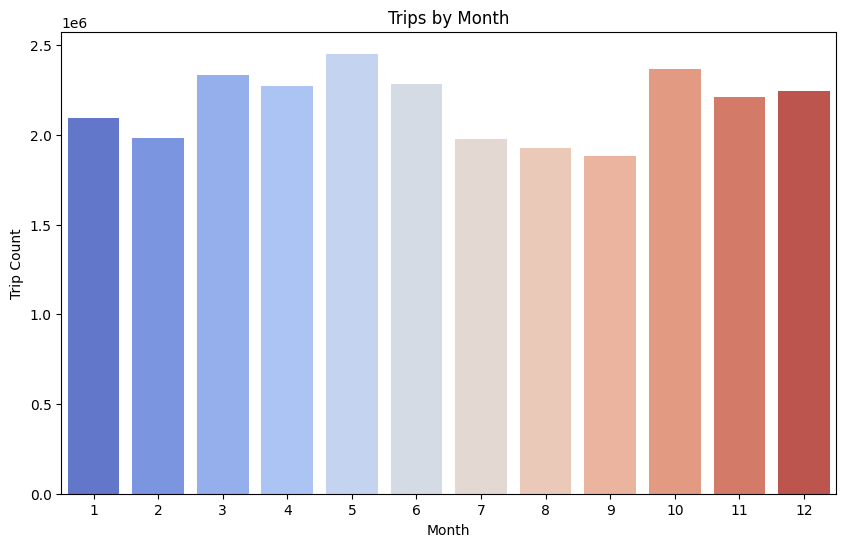

In [52]:

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x ='month', y='trip_count', data= monthly_demand, palette='coolwarm')
plt.title('Trips by Month')
plt.xlabel('Month')
plt.ylabel('Trip Count')
plt.show()

In [53]:
df2024.shape

(20332093, 6)

In [54]:
pd.DataFrame({
    'feature': df2024.columns.values,
    'data_type': df2024.dtypes.values,
    'null_value(%)': df2024.isna().mean().values * 100,
    'neg_value(%)': [len(df2024[col][df2024[col] < 0]) / len(df2024) * 100 if col in df2024.select_dtypes(include=[np.number]).columns else 0 for col in df2024.columns],
    '0_value(%)': [len(df2024[col][df2024[col] == 0]) / len(df2024) * 100 if col in df2024.select_dtypes(include=[np.number]).columns else 0 for col in df2024.columns],
    'duplicate' : df2024.duplicated().sum(),
    'min': [df2024[col].min() if col in df2024.select_dtypes(include=[np.number]).columns else None for col in df2024.columns],
    'max': [df2024[col].max() if col in df2024.select_dtypes(include=[np.number]).columns else None for col in df2024.columns],
    'n_unique': df2024.nunique().values,
    'sample_unique': [df2024[col].unique() for col in df2024.columns]}
).round(3)

,feature,data_type,null_value(%),neg_value(%),0_value(%),duplicate,min,max,n_unique,sample_unique
0,tpep_pickup_datetime,datetime64[us],0.000,0.000,0.000,12,NaN,NaN,9955675,"[2024-01-01 00:57:55, 2024-01-01 00:03:00, 202..."
1,tpep_dropoff_datetime,datetime64[us],0.000,0.000,0.000,12,NaN,NaN,9948395,"[2024-01-01 01:17:43, 2024-01-01 00:09:36, 202..."
2,passenger_count,float64,9.719,0.000,1.087,12,0.00,9.00,10,"[1.0, 2.0, 0.0, 4.0, 3.0, 5.0, 6.0, 8.0, 7.0, ..."
3,trip_distance,float64,0.000,0.000,1.792,12,0.00,312722.30,7056,"[1.72, 1.8, 4.7, 1.4, 0.8, 10.82, 3.0, 5.44, 0..."
4,fare_amount,float64,0.000,1.553,0.041,12,-1285.40,334076.32,14681,"[17.7, 10.0, 23.3, 7.9, 29.6, 45.7, 25.4, 31.0..."
5,total_amount,float64,0.000,1.266,0.012,12,-1315.97,334145.30,33401,"[22.7, 18.75, 31.3, 17.0, 16.1, 41.5, 64.95, 3..."


In [55]:
df2024[df2024.duplicated()]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount
701034,2024-01-09 14:25:35,2024-01-09 14:32:45,1.0,0.79,7.9,11.90
785990,2024-01-10 14:25:58,2024-01-10 14:35:57,1.0,1.39,10.7,17.64
1678531,2024-01-19 22:08:32,2024-01-19 22:17:07,1.0,1.26,9.3,17.16
754252,2024-02-08 18:23:50,2024-02-08 18:38:14,1.0,0.81,12.8,23.16
2083394,2024-03-21 08:47:48,2024-03-21 08:52:03,1.0,0.67,5.8,9.80
2851090,2024-03-28 19:28:26,2024-03-28 19:41:46,1.0,1.90,14.2,24.80
1889302,2024-04-18 23:21:04,2024-04-18 23:27:16,1.0,0.90,7.2,14.65
2408419,2024-04-24 10:56:58,2024-04-24 10:57:08,1.0,0.00,3.0,7.00
509639,2024-05-05 12:02:36,2024-05-05 12:09:57,1.0,1.00,8.6,15.10
95416,2024-06-01 21:32:13,2024-06-01 21:55:12,1.0,3.45,22.6,30.60


In [56]:
df2023.drop_duplicates(inplace= True)

In [57]:
duplicate_value = df2024[df2024.duplicated(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance'], keep=False)]
duplicate_value

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount
99,2024-01-01 00:18:24,2024-01-01 00:30:39,1.0,2.16,-13.50,-18.50
100,2024-01-01 00:18:24,2024-01-01 00:30:39,1.0,2.16,13.50,18.50
506,2024-01-01 00:04:00,2024-01-01 00:04:44,1.0,0.01,-31.50,-34.25
507,2024-01-01 00:04:00,2024-01-01 00:04:44,1.0,0.01,31.50,34.25
536,2024-01-01 00:41:42,2024-01-01 00:46:00,1.0,0.47,-5.80,-10.80
...,...,...,...,...,...,...
3341361,2024-06-16 00:27:00,2024-06-16 00:36:00,NaN,1.88,19.48,23.48
3372158,2024-06-18 16:51:00,2024-06-18 17:09:00,NaN,2.66,18.92,20.42
3372569,2024-06-18 16:51:00,2024-06-18 17:09:00,NaN,2.66,17.37,21.37
3405783,2024-06-21 18:55:00,2024-06-21 19:11:00,NaN,2.21,18.11,22.11


In [58]:
dup_negative_val = duplicate_value[duplicate_value['fare_amount']<0]
dup_negative_val 

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount
99,2024-01-01 00:18:24,2024-01-01 00:30:39,1.0,2.16,-13.5,-18.50
506,2024-01-01 00:04:00,2024-01-01 00:04:44,1.0,0.01,-31.5,-34.25
536,2024-01-01 00:41:42,2024-01-01 00:46:00,1.0,0.47,-5.8,-10.80
552,2024-01-01 00:42:02,2024-01-01 01:14:33,1.0,5.48,-33.1,-38.10
682,2024-01-01 00:24:02,2024-01-01 01:10:32,1.0,8.74,-47.8,-52.80
...,...,...,...,...,...,...
3128236,2024-06-30 23:03:55,2024-06-30 23:12:30,3.0,0.91,-6.5,-11.50
3128264,2024-06-30 23:47:55,2024-07-01 00:36:20,2.0,5.38,-43.6,-48.60
3128357,2024-06-30 23:19:00,2024-06-30 23:54:15,2.0,17.77,-70.0,-82.69
3128387,2024-06-30 23:47:08,2024-06-30 23:47:13,1.0,0.00,-86.0,-92.50


In [59]:
df2024.drop(dup_negative_val.index, inplace=True)

In [60]:
df2024[df2024.duplicated(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime',  'passenger_count', 'trip_distance'])]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount
6956,2024-01-01 01:53:45,2024-01-01 02:25:58,1.0,2.97,0.00,4.00
15731,2024-01-01 02:15:52,2024-01-01 02:46:49,2.0,8.86,0.00,4.00
20848,2024-01-01 04:28:12,2024-01-01 04:28:27,1.0,0.00,0.00,1.50
20850,2024-01-01 04:29:46,2024-01-01 04:30:01,1.0,0.00,0.00,1.00
40344,2024-01-01 14:57:35,2024-01-01 14:57:46,1.0,0.00,0.00,1.50
...,...,...,...,...,...,...
3269203,2024-06-09 12:40:00,2024-06-09 13:06:00,NaN,4.54,27.44,31.44
3320358,2024-06-14 18:49:00,2024-06-14 19:05:00,NaN,2.60,20.86,24.86
3341361,2024-06-16 00:27:00,2024-06-16 00:36:00,NaN,1.88,19.48,23.48
3372569,2024-06-18 16:51:00,2024-06-18 17:09:00,NaN,2.66,17.37,21.37


In [61]:
df2024.drop_duplicates(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance'], keep=False)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount
0,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,17.70,22.70
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,10.00,18.75
2,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,23.30,31.30
3,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,10.00,17.00
4,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,7.90,16.10
...,...,...,...,...,...,...
3539188,2024-06-30 23:07:36,2024-06-30 23:18:35,NaN,2.51,21.09,25.09
3539189,2024-06-30 23:46:07,2024-07-01 00:11:53,NaN,7.55,33.96,37.96
3539190,2024-06-30 23:18:50,2024-06-30 23:35:09,NaN,4.25,21.01,25.01
3539191,2024-06-30 23:33:36,2024-06-30 23:42:37,NaN,1.60,14.41,18.41


In [62]:
df2024.shape

(18868901, 6)

In [63]:
df2024[df2024.duplicated(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime',  'passenger_count', 'trip_distance'])]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount
6956,2024-01-01 01:53:45,2024-01-01 02:25:58,1.0,2.97,0.00,4.00
15731,2024-01-01 02:15:52,2024-01-01 02:46:49,2.0,8.86,0.00,4.00
20848,2024-01-01 04:28:12,2024-01-01 04:28:27,1.0,0.00,0.00,1.50
20850,2024-01-01 04:29:46,2024-01-01 04:30:01,1.0,0.00,0.00,1.00
40344,2024-01-01 14:57:35,2024-01-01 14:57:46,1.0,0.00,0.00,1.50
...,...,...,...,...,...,...
3269203,2024-06-09 12:40:00,2024-06-09 13:06:00,NaN,4.54,27.44,31.44
3320358,2024-06-14 18:49:00,2024-06-14 19:05:00,NaN,2.60,20.86,24.86
3341361,2024-06-16 00:27:00,2024-06-16 00:36:00,NaN,1.88,19.48,23.48
3372569,2024-06-18 16:51:00,2024-06-18 17:09:00,NaN,2.66,17.37,21.37


In [64]:
print(df2024.index.duplicated().sum())

15392858


In [65]:
df2024.reset_index(drop=True, inplace=True)

In [66]:
print(df2024.index.duplicated().sum())

0


In [67]:
df2024.shape

(18868901, 6)

In [68]:
pd.DataFrame({
    'feature': df2024.columns.values,
    'neg_value(%)': [len(df2024[col][df2024[col] < 0]) / len(df2024) * 100 if np.issubdtype(df2024[col].dtype, np.number) else 0 for col in df2024.columns]
}).round(3)

,feature,neg_value(%)
0,tpep_pickup_datetime,0.000
1,tpep_dropoff_datetime,0.000
2,passenger_count,0.000
3,trip_distance,0.000
4,fare_amount,0.311
5,total_amount,0.006


In [69]:
negative_val  = df2023[df2023['fare_amount']<0]
df2023.loc[negative_val.index, 'fare_amount'] = df2023['fare_amount'].abs()

In [70]:
pd.DataFrame({
    'feature': df2024.columns.values,
    'data_type': df2024.dtypes.values,
    '0_value(%)': [len(df2024[col][df2024[col] == 0]) / len(df2024) * 100 if np.issubdtype(df2024[col].dtype, np.number) else 0 for col in df2024.columns]
}).round(3)

,feature,data_type,0_value(%)
0,tpep_pickup_datetime,datetime64[us],0.000
1,tpep_dropoff_datetime,datetime64[us],0.000
2,passenger_count,float64,1.096
3,trip_distance,float64,1.714
4,fare_amount,float64,0.042
5,total_amount,float64,0.012


In [71]:
median_passenger_count = df2024[df2024['passenger_count'] > 0]['passenger_count'].median()
df2024['passenger_count'] = df2024['passenger_count'].apply(lambda x: x if (x > 0 )  else median_passenger_count)

df2024 = df2024[df2024['trip_distance']>0]
df2024 = df2024[df2024['fare_amount']>0]

In [72]:
pd.DataFrame({
    'feature': df2024.columns.values,
    'data_type': df2024.dtypes.values,
    'null_value(%)': df2024.isna().mean().values * 100
}).round(3)

,feature,data_type,null_value(%)
0,tpep_pickup_datetime,datetime64[us],0.0
1,tpep_dropoff_datetime,datetime64[us],0.0
2,passenger_count,float64,0.0
3,trip_distance,float64,0.0
4,fare_amount,float64,0.0
5,total_amount,float64,0.0


In [73]:
df2024['passenger_count'].fillna(df2024['passenger_count'].median(), inplace=True)
df2024['passenger_count'].value_counts()

C:\Users\ACER\AppData\Local\Temp\ipykernel_33336\2787419272.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2024['passenger_count'].fillna(df2024['passenger_count'].median(), inplace=True)


passenger_count
1.0    14900684
2.0     2416824
3.0      554721
4.0      319973
5.0      172968
6.0      116794
8.0          63
7.0          13
9.0          10
Name: count, dtype: int64

In [74]:
outliers = df2024[(df2024['tpep_pickup_datetime'].dt.year!=2024)]
outliers

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount
239,2023-12-31 23:56:46,2024-01-01 00:12:06,2.0,2.38,15.6,21.60
342,2023-12-31 23:39:17,2023-12-31 23:42:00,2.0,0.47,5.1,10.10
1961,2023-12-31 23:57:17,2024-01-01 00:01:50,1.0,0.53,5.8,12.96
2310,2023-12-31 23:56:45,2024-01-01 00:00:28,1.0,0.97,6.5,13.50
2629,2023-12-31 23:49:12,2024-01-01 00:04:32,1.0,3.14,17.0,28.60
2796,2023-12-31 23:47:28,2023-12-31 23:57:07,2.0,1.44,10.7,18.84
3662,2023-12-31 23:58:35,2024-01-01 00:13:06,6.0,8.39,33.1,42.35
3666,2023-12-31 23:58:37,2024-01-01 00:08:37,2.0,0.59,10.0,18.75
7771,2023-12-31 23:54:27,2024-01-01 00:13:12,1.0,7.70,33.1,45.72
9895,2009-01-01 23:58:40,2009-01-02 00:01:40,1.0,0.46,4.4,9.40


In [75]:
df2024.drop(outliers.index, inplace=True)

In [76]:
df2024[(df2024['tpep_pickup_datetime'].dt.year!=2024)]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount


In [77]:
time_bins = [0, 5, 11, 15, 20, 24] 
time_labels = ['Midnight', 'Morning', 'Noon', 'Evening', 'Night']
df2024['pickup_time'] = pd.cut(df2024['tpep_pickup_datetime'].dt.hour, bins=time_bins, labels=time_labels, right=False)

df2024['day_category'] = df2024['tpep_pickup_datetime'].dt.day_name().apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekdays')

In [78]:
df2024 = df2024[df2024['trip_distance']>1]

In [79]:
df2024[df2024['trip_distance']>120].sort_values(by='trip_distance', ascending=False).head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount,pickup_time,day_category
2723844,2024-01-30 06:37:00,2024-01-30 06:50:00,1.0,312722.30,14.46,22.15,Morning,Weekdays
12068475,2024-04-26 21:08:00,2024-04-26 21:29:00,1.0,270766.80,29.22,33.22,Night,Weekdays
11833108,2024-04-08 05:19:00,2024-04-08 05:22:00,1.0,268958.23,8.08,12.08,Morning,Weekdays
15433180,2024-05-18 21:21:00,2024-05-18 21:31:00,1.0,249151.44,16.30,20.30,Night,Weekend
15541229,2024-05-28 08:45:00,2024-05-28 09:26:00,1.0,241289.24,57.03,61.03,Morning,Weekdays


In [80]:
df2024 = df2024[df2024['trip_distance']<120]

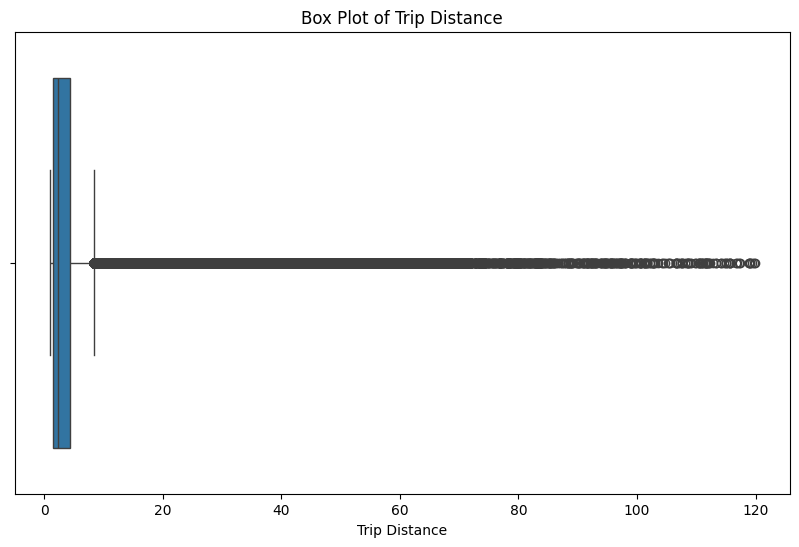

In [81]:
# Create a boxplot for trip_distance
plt.figure(figsize=(10, 6))
sns.boxplot(x=df2024['trip_distance'])
plt.title('Box Plot of Trip Distance')
plt.xlabel('Trip Distance')
plt.show()

In [82]:
df2024[df2024['fare_amount']>120].sort_values(by='fare_amount', ascending=False).head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount,pickup_time,day_category
1068379,2024-01-14 10:08:11,2024-01-16 13:54:22,1.0,31.95,2221.3,2225.3,Morning,Weekend
4300962,2024-02-18 14:13:36,2024-02-18 14:16:18,1.0,1.07,999.0,1000.0,Noon,Weekend
5009388,2024-02-26 19:18:19,2024-02-27 15:33:07,1.0,36.20,924.9,931.4,Evening,Weekdays
9519603,2024-04-08 07:19:52,2024-04-08 10:48:19,1.0,115.63,873.1,874.6,Morning,Weekdays
5283673,2024-02-29 17:06:32,2024-02-29 20:08:18,5.0,118.87,821.3,854.8,Evening,Weekdays


In [83]:
diff = (df2024['tpep_dropoff_datetime'] - df2024['tpep_pickup_datetime']).dt.total_seconds()/60
df2024['trip_duration'] = diff.round(2)

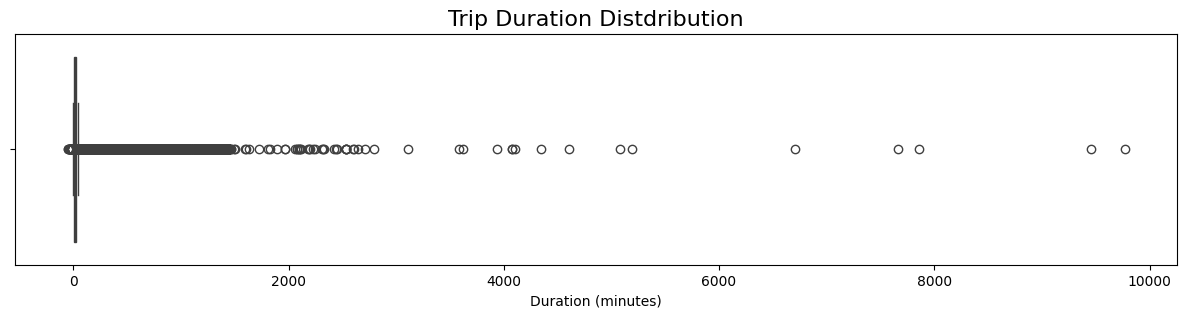

In [84]:
plt.figure(figsize=(15, 3))

sns.boxplot(data=df2024, x='trip_duration')
plt.xlabel('Duration (minutes)')
plt.title('Trip Duration Distdribution', fontsize=16)


plt.show()

In [85]:
df2024[df2024['trip_duration']>700].sort_values(by='trip_duration', ascending=False).head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount,pickup_time,day_category,trip_duration
9592787,2024-04-08 23:16:11,2024-04-15 18:03:42,1.0,13.62,1.0,18.26,Night,Weekdays,9767.52
1944692,2024-01-24 17:03:14,2024-01-31 06:38:38,1.0,2.26,30.3,36.80,Evening,Weekdays,9455.40
13006989,2024-05-09 19:03:38,2024-05-15 06:05:29,1.0,14.62,70.0,87.69,Evening,Weekdays,7861.85
16136323,2024-06-06 16:18:13,2024-06-11 23:56:51,1.0,8.19,55.5,66.25,Evening,Weekdays,7658.63
11116620,2024-04-24 21:36:24,2024-04-29 13:23:38,1.0,11.26,43.6,47.85,Night,Weekdays,6707.23


In [86]:
df2024 = df2024[df2024['trip_duration']<700]

In [87]:
df2024 = df2024[df2024['trip_duration']>0]

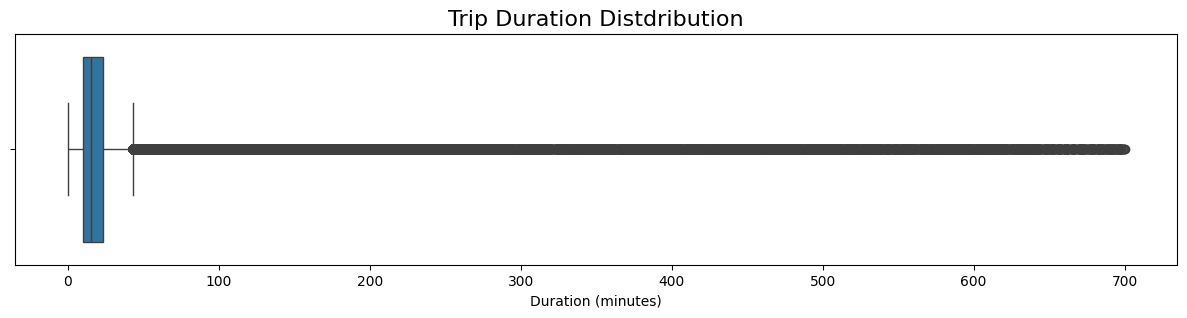

In [88]:
plt.figure(figsize=(15, 3))

sns.boxplot(data=df2023, x='trip_duration')
plt.xlabel('Duration (minutes)')
plt.title('Trip Duration Distdribution', fontsize=16)


plt.show()

In [89]:
# Extract hour, day of the week, month, and season from pickup datetime
df2024['hour'] = df2024['tpep_pickup_datetime'].dt.hour
df2024['day_of_week'] = df2024['tpep_pickup_datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
df2024['month'] = df2024['tpep_pickup_datetime'].dt.month

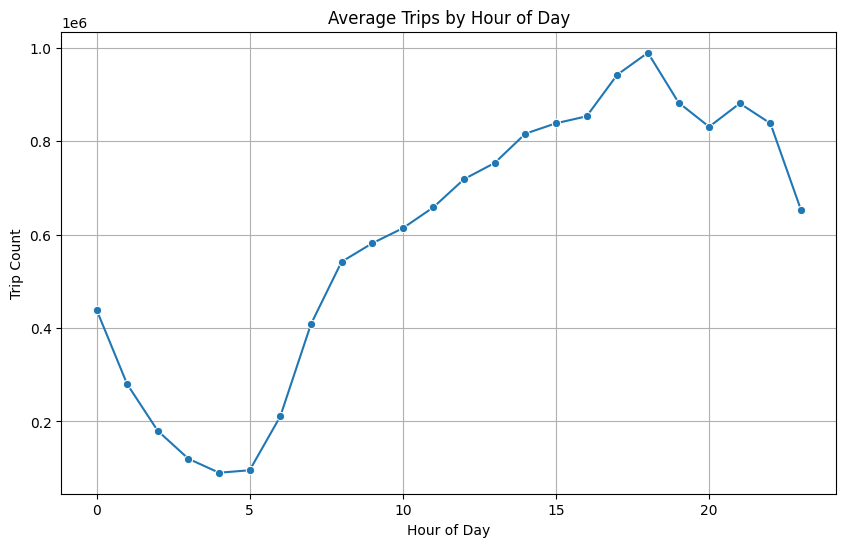

In [90]:
# Aggregate trips by hour
hourly_demand = df2024.groupby('hour').size().reset_index(name='trip_count')

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='trip_count', data=hourly_demand, marker='o')
plt.title('Average Trips by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Trip Count')
plt.grid()
plt.show()

           ds      y
0  2023-01-01  55506
1  2023-01-02  46180
2  2023-01-03  58381
3  2023-01-04  65232
4  2023-01-05  69118


14:47:07 - cmdstanpy - INFO - Chain [1] start processing
14:47:08 - cmdstanpy - INFO - Chain [1] done processing


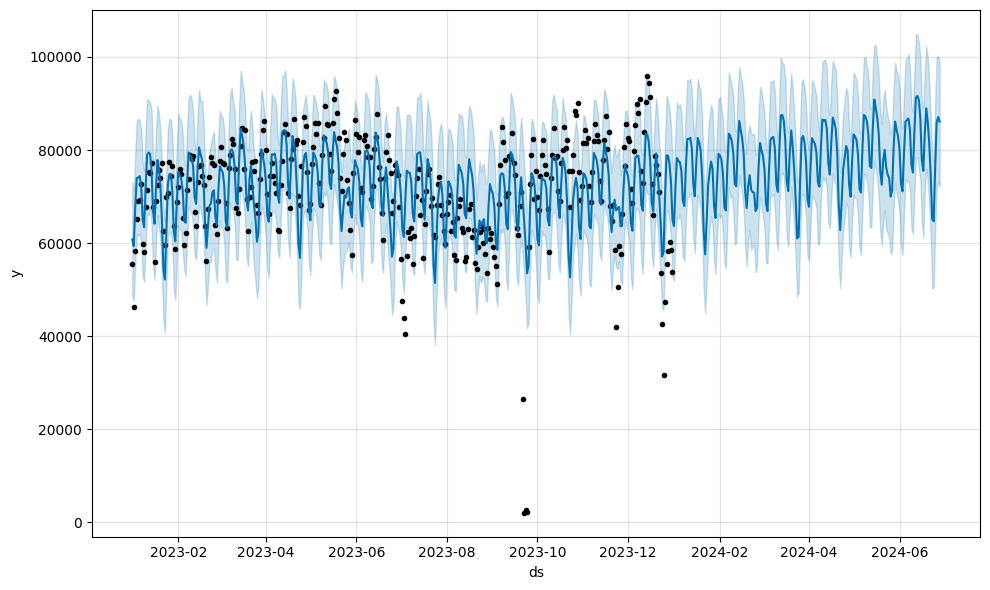

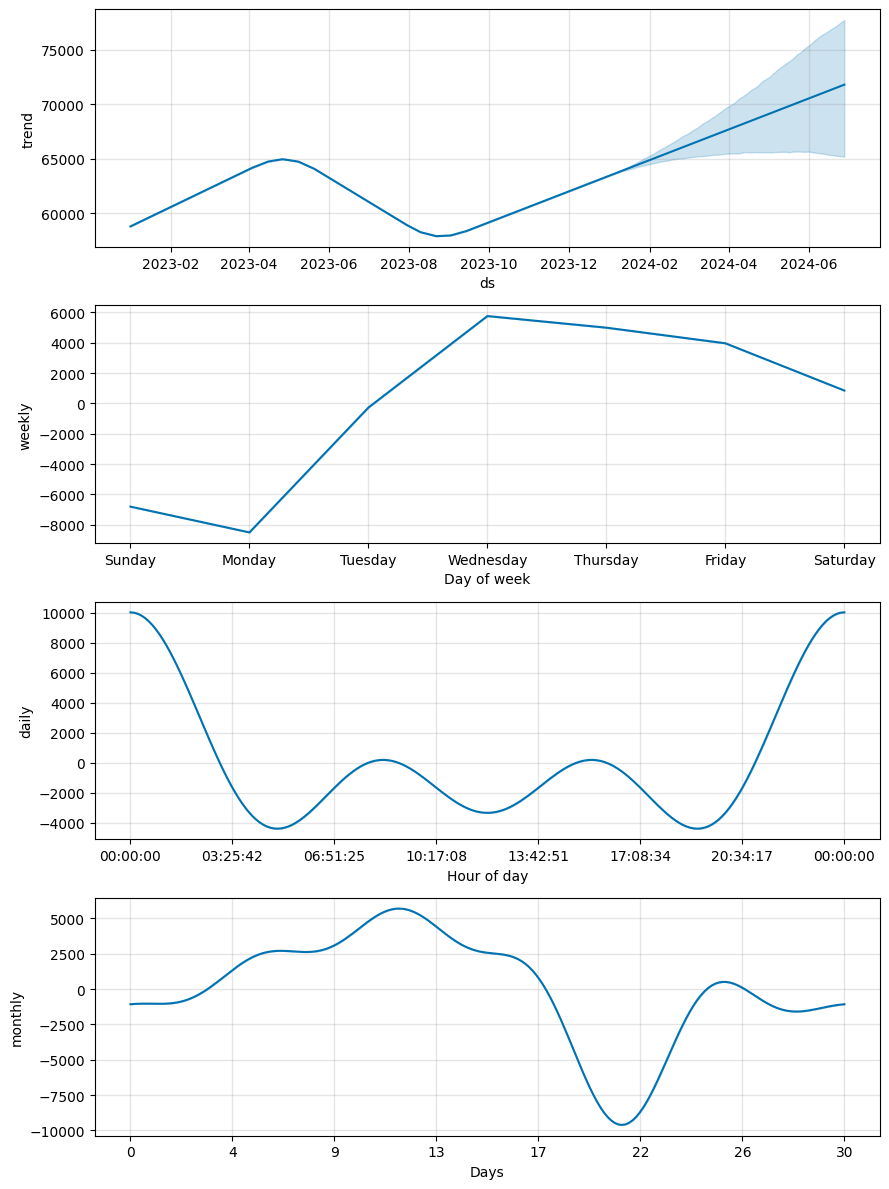

In [91]:
# Step 1: Convert the pickup datetime to date if you want daily aggregation
df2023['date'] = pd.to_datetime(df2023['tpep_pickup_datetime']).dt.date

# Step 2: Aggregate the data by date (daily taxi demand)
df2023_daily = df2023.groupby('date').size().reset_index(name='pickups')

# Step 3: Rename the columns for Prophet
df2023_daily = df2023_daily.rename(columns={'date': 'ds', 'pickups': 'y'})

# Check the resulting DataFrame
print(df2023_daily.head())

df2023_daily['ds']=pd.to_datetime(df2023_daily['ds'])

# Step 1: Initialize the Prophet model
model = Prophet(changepoint_prior_scale=0.05)
# Adding custom seasonality for weekly and daily patterns (if applicable)
model.add_seasonality(name='weekly', period=7, fourier_order=2)
model.add_seasonality(name='daily', period=1, fourier_order=3)
model.add_seasonality(name='monthly', period=30.44, fourier_order=5)

# Step 2: Train the model using the daily taxi demand data
model.fit(df2023_daily)

# Step 3: Create a dataframe for future predictions (let's forecast for the next 365 days, or as per your requirement)
future1 = model.make_future_dataframe(periods=180)  # Adjust 'periods' if you want more/less prediction time

# Step 4: Predict the future taxi demand
forecast = model.predict(future1)

# Step 5: Inspect the forecast dataframe (contains the predictions and other useful information)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig = model.plot(forecast)

# Step 2: Optionally, plot the forecast components (e.g., trend, seasonality)
fig2 = model.plot_components(forecast)

# Display the plots
plt.show()

In [92]:
# Step 1: Convert the pickup datetime to date if you want daily aggregation
df2024['date'] = pd.to_datetime(df2024['tpep_pickup_datetime']).dt.date

# Step 2: Aggregate the data by date (daily taxi demand)
df2024_daily_demand = df2024.groupby('date').size().reset_index(name='pickups')

# Step 3: Rename the columns for Prophet
df2024_daily_demand = df2024_daily_demand.rename(columns={'date': 'ds', 'pickups': 'y'})

# Check the resulting DataFrame
print(df2024_daily_demand.head())


           ds      y
0  2024-01-01  57582
1  2024-01-02  53003
2  2024-01-03  57029
3  2024-01-04  71943
4  2024-01-05  71239


In [93]:
df2024_daily_demand['ds']=pd.to_datetime(df2024_daily_demand['ds'])

In [94]:
# Merge forecasted and actual data on 'ds' (date)
comparison_df = pd.merge(forecast, df2024_daily_demand, on='ds', how='inner')
# MAE (Mean Absolute Error)
mae = mean_absolute_error(comparison_df['y'], comparison_df['yhat'])
# RMSE (Root Mean Squared Error)
rmse = root_mean_squared_error(comparison_df['y'], comparison_df['yhat'])
# MAPE (Mean Absolute Percentage Error)
mape = mean_absolute_percentage_error(comparison_df['y'], comparison_df['yhat'])

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')


MAE: 6892.943946538229
RMSE: 8770.956216919876
MAPE: 0.09277875136923078%


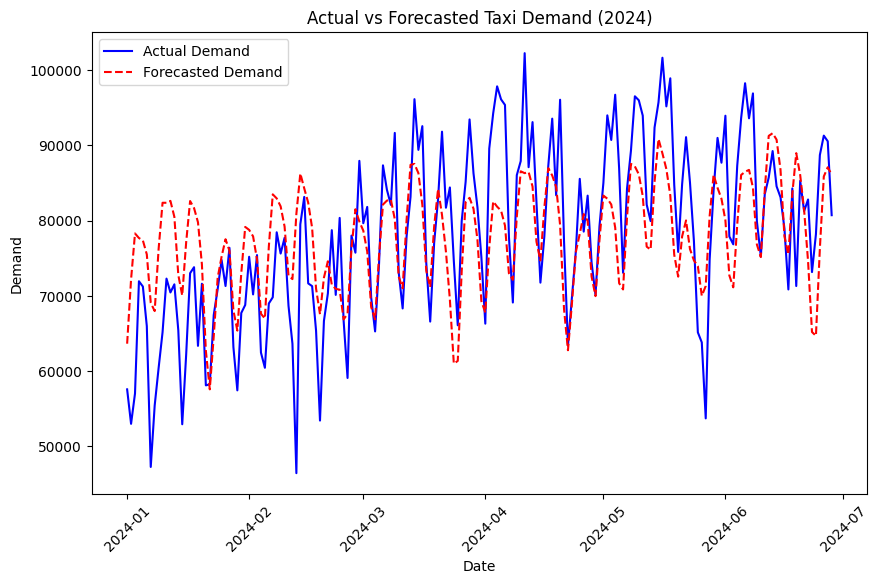

In [95]:
# Plot forecasted vs actual revenue
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['ds'], comparison_df['y'], label='Actual Demand', color='blue')
plt.plot(comparison_df['ds'], comparison_df['yhat'], label='Forecasted Demand', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Actual vs Forecasted Taxi Demand (2024)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

14:47:18 - cmdstanpy - INFO - Chain [1] start processing
14:47:18 - cmdstanpy - INFO - Chain [1] done processing


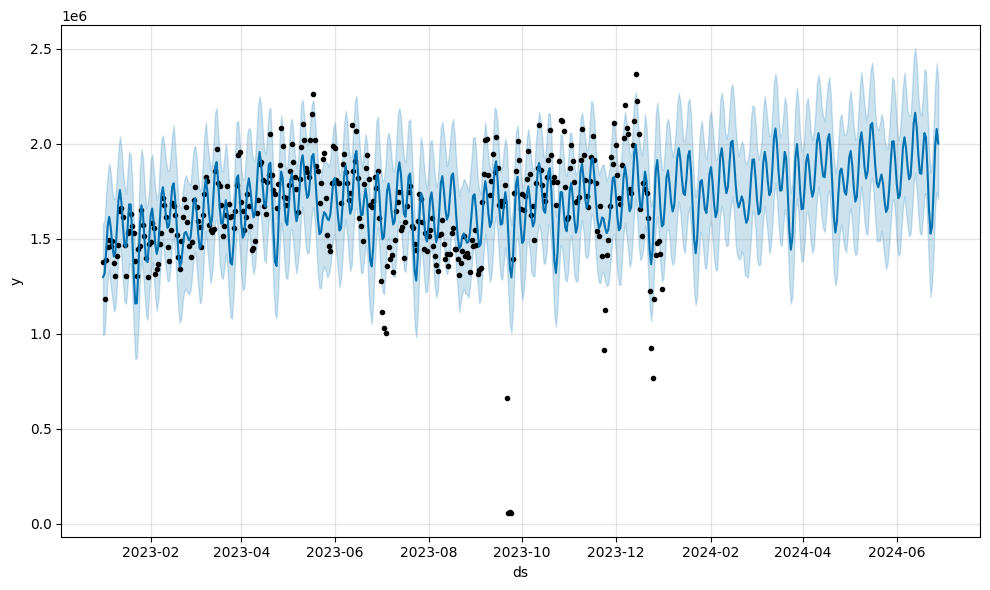

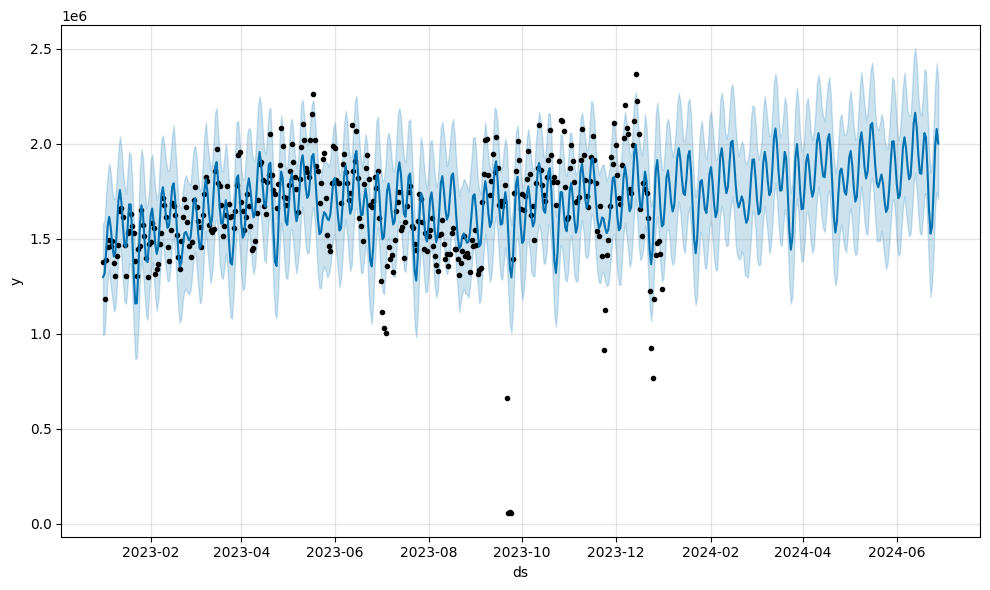

In [96]:

# Aggregate the daily total fare
df2023['date'] = df2023['tpep_pickup_datetime'].dt.date
daily_revenue = df2023.groupby('date')['fare_amount'].sum().reset_index()

# Rename columns for convenience
daily_revenue.columns = ['ds', 'y']
# Initialize the model
revenue_model = Prophet(changepoint_prior_scale=0.05, seasonality_prior_scale=90)
# Adding custom seasonality for weekly and daily patterns (if applicable)
revenue_model.add_seasonality(name='weekly', period=7, fourier_order=2)
revenue_model.add_seasonality(name='daily', period=1, fourier_order=3)
revenue_model.add_seasonality(name='monthly', period=30.44, fourier_order=5)

# Fit the revenue model on the aggregated data
revenue_model.fit(daily_revenue)

# Make future data frame for prediction (e.g., for 2024)
future_revenue = revenue_model.make_future_dataframe(periods=180)

# Forecast the revenue
forecast_revenue = revenue_model.predict(future_revenue)

# Plot the forecast
revenue_model.plot(forecast_revenue)
# revenue_model.plot_components(forecast_revenue)

In [97]:
# Aggregate total revenue by date
df2024_actual_revenue = df2024.groupby('date').agg({'fare_amount': 'sum'}).reset_index()

# Rename columns for consistency
df2024_actual_revenue.rename(columns={'date': 'ds', 'fare_amount': 'y'}, inplace=True)
df2024_actual_revenue['ds'] = pd.to_datetime(df2024_actual_revenue['ds'])

In [98]:
# Merge forecasted and actual data on 'ds' (date)
comparison_revenue_df = pd.merge(forecast_revenue, df2024_actual_revenue, on='ds', how='inner')
# MAE (Mean Absolute Error)
mae = mean_absolute_error(comparison_revenue_df['y'], comparison_revenue_df['yhat'])
# RMSE (Root Mean Squared Error)
rmse = root_mean_squared_error(comparison_revenue_df['y'], comparison_revenue_df['yhat'])
# MAPE (Mean Absolute Percentage Error)
mape = mean_absolute_percentage_error(comparison_revenue_df['y'], comparison_revenue_df['yhat'])

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')


MAE: 196352.04393031838
RMSE: 239582.33615802097
MAPE: 0.12074802413836237%


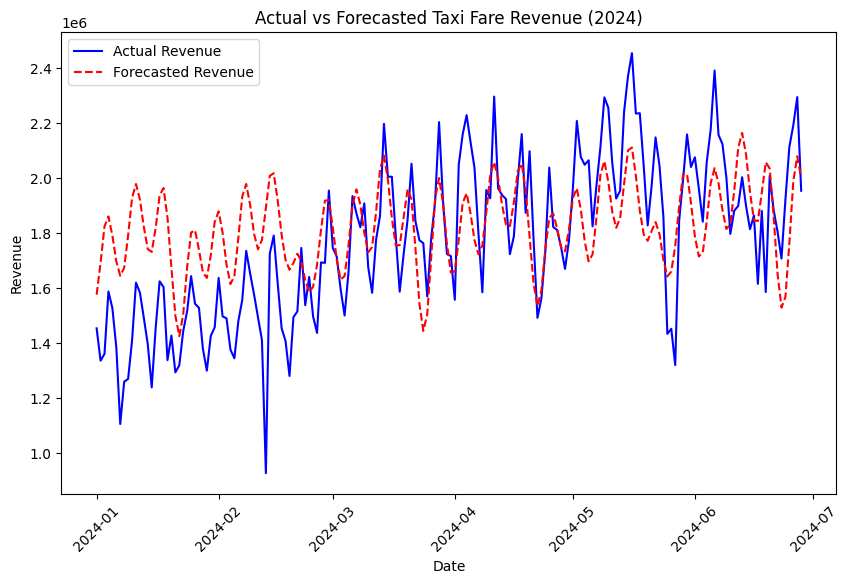

In [99]:
# Plot forecasted vs actual revenue
plt.figure(figsize=(10, 6))
plt.plot(comparison_revenue_df['ds'], comparison_revenue_df['y'], label='Actual Revenue', color='blue')
plt.plot(comparison_revenue_df['ds'], comparison_revenue_df['yhat'], label='Forecasted Revenue', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Actual vs Forecasted Taxi Fare Revenue (2024)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [100]:
from prophet.diagnostics import cross_validation

# Perform cross-validation
df_cv = cross_validation(revenue_model, initial='120 days', period='30 days', horizon='60 days')


  0%|          | 0/7 [00:00<?, ?it/s]14:47:19 - cmdstanpy - INFO - Chain [1] start processing
14:47:19 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:01,  4.41it/s]14:47:20 - cmdstanpy - INFO - Chain [1] start processing
14:47:20 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:00<00:00,  5.45it/s]14:47:20 - cmdstanpy - INFO - Chain [1] start processing
14:47:20 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:00<00:00,  6.10it/s]14:47:20 - cmdstanpy - INFO - Chain [1] start processing
14:47:20 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:00<00:00,  6.27it/s]14:47:20 - cmdstanpy - INFO - Chain [1] start processing
14:47:20 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:00<00:00,  6.54it/s]14:47:20 - cmdstanpy - INFO - Chain [1] start processing
14:47:20 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 6/7 [00:00<00:00,  6.43it/s]14:47:20 - cmds

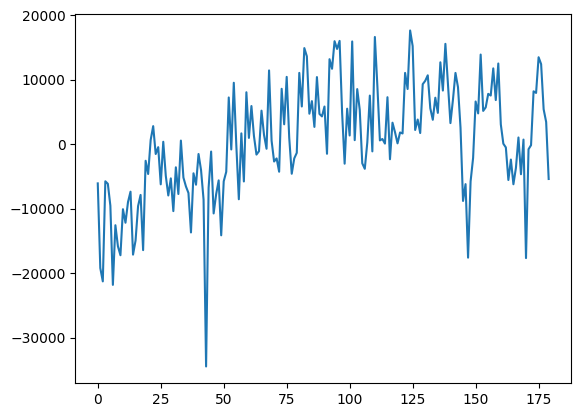

In [101]:
forecast_residuals = comparison_df['y'] - comparison_df['yhat']
plt.plot(forecast_residuals)
plt.show()
